## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport -os, -np, -sys

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d  # for 3d plot
import simulation as sim  # self written classes, functions

## Run simulation

In [3]:
# creating instances
surface = sim.RefractiveSurface(1.4, 1)  # quartzglas to air
detector = sim.Detector(5, 0.5)  # 5cm distance, 0.5cm window diameter
ray = sim.Ray([0,0,0], [1,1,1])

Surface total reflection: 45.58469140280703°
Opening angle of detector window: 2.862405226111748°


In [4]:
# number positions detector will scan
detector.steps = 100

In [5]:
# generating initial ray directions
directions = sim.get_random_directions(1000000)

In [6]:
# throwing unimporting rays away to increase speed
good_directions = []
# maximal y-value ray can have and still hit detector
max_y = detector._window_diameter / 2 / detector._distance
for direction in directions:
    # discard if z-value <= 0
    if direction[2] <= 0:
        continue
    # discard if y-value outside detector even before refraction, 
    # since refraction will increase y-value
    if np.abs(direction[1]) > max_y:
        continue
    good_directions.append(direction)
directions = np.array(good_directions)

In [7]:
refracted_rays = []
for direction in directions:
    ray.intensity = 1  # reset intensity
    ray.direction = direction
    ray.refract(surface)
    # discard if z-value <= 0
    if ray.direction[2] <= 0:
        continue
    # create 4 dimesional vectors with last dimension intensity
    refracted_rays.append(np.append(ray.direction, ray.intensity))
refracted_rays = np.array(refracted_rays)
print(f"Rays that could hit detector: {len(refracted_rays)}")

Rays that could hit detector: 12495


In [8]:
bins_intensity = []
bins_histo = []
angular_positions = []
# iterating detector positions
for angular_position, detector_direction in detector:
    intensities = []
    angular_positions.append(angular_position)
    for ray0 in refracted_rays:
        # check if detector got hit by comparing angle between ray and detector direction
        # with opening angle of detector
        angle = np.arccos(ray0[:-1] @ detector_direction) * sim.CONVERT_TO_DEG
        if angle <= detector.d_angle:
            intensities.append(ray0[3])
    bins_intensity.append(sum(intensities))
    bins_histo.append(len(intensities))

## Plotting Histogram

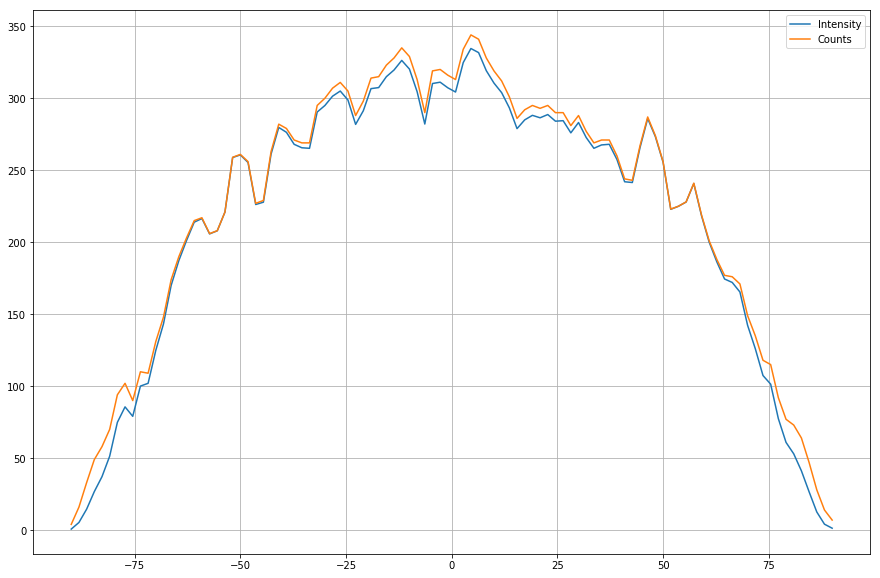

In [9]:
fig = plt.figure(figsize=(15,10))
plt.grid()
plt.plot(angular_positions, bins_intensity, label="Intensity")
plt.plot(angular_positions, bins_histo, label="Counts")
plt.legend()
# plt.savefig('sim_difference_fresnel.pdf')

## 3D Plot

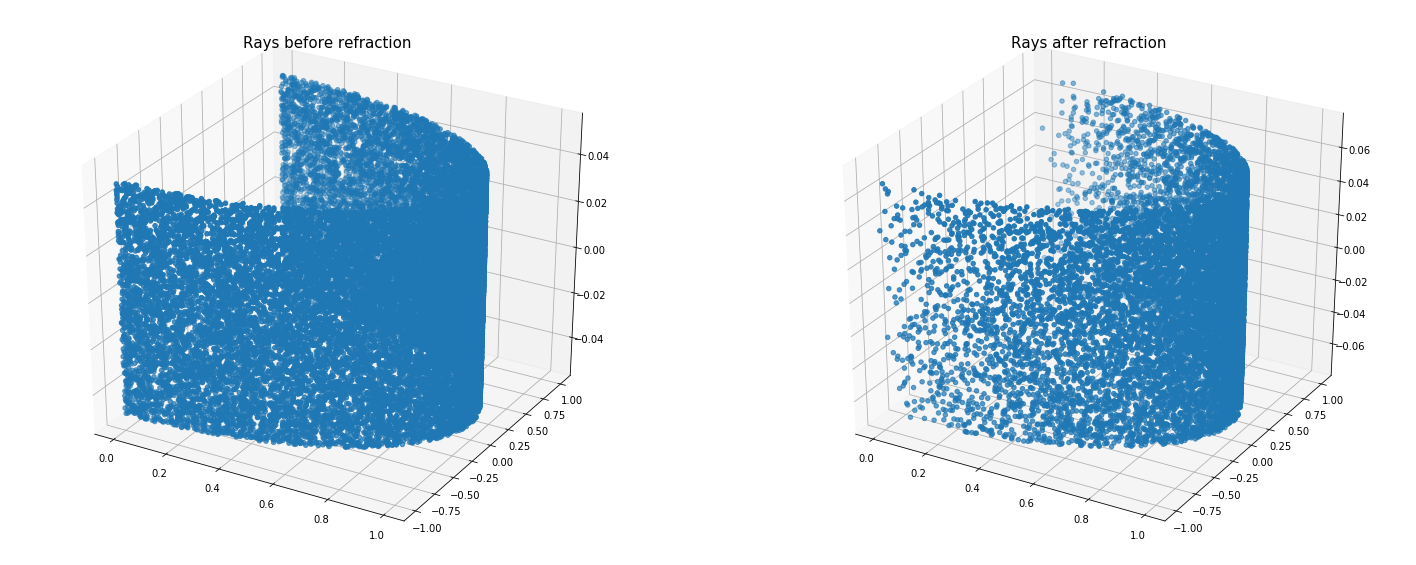

In [10]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(directions.T[2], directions.T[0], directions.T[1])
ax1.set_title("Rays before refraction", fontsize=15)
ax2.scatter(refracted_rays.T[2], refracted_rays.T[0], refracted_rays.T[1])
ax2.set_title("Rays after refraction", fontsize=15);